# Compare Politeness in China and in the US

## Import Modules

In [1]:
import pandas as pd
from tqdm import tqdm
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from html import unescape
from itertools import product

import matplotlib as mpl
font_cn = mpl.font_manager.FontProperties(fname='fonts/SourceHanSansSC-Normal.otf')
font_cn.set_weight = 'normal'
from scipy import stats # For in-built method to get PCC

## Load Annotated Data

/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


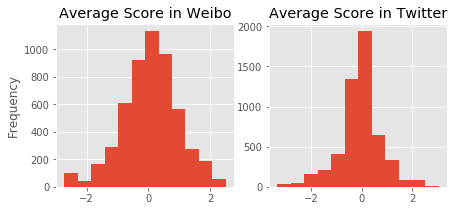

,Twitter,Weibo
count,5300.000,5300.000
mean,0.153,-0.041
std,1.001,1.041
min,-3.000,-3.000
25%,-0.500,-0.500
50%,0.500,0.000
75%,0.500,0.500
max,3.000,3.000
median,0.500,0.000


In [21]:
HDF_FPATH = 'data_200516.hdf' # Weibo = 3245+3000 -> 6226 ; Twitter = 3083+3000 -> 5375
NUM_POSTS = 5300
# Annotators to use in analysis.
WEIBO_ANNOTATORS = list('ABCD')
TWITR_ANNOTATORS = list('ABDE')

FILE_SUFFIX = f'{NUM_POSTS}_Weibo{"".join(WEIBO_ANNOTATORS)}Twitr{"".join(TWITR_ANNOTATORS)}'

standardize = lambda df: (df-df.mean())/df.std()

# Tokens are only used in selecting representative posts.
weibo_tokens = pd.read_hdf(HDF_FPATH, 'Weibo2014_3245+3000_token')
twitr_tokens = pd.read_hdf(HDF_FPATH, 'TwtUs2014_3083+3000_token')

def loadAnnots(csv_path: str, annotators: list, index_cols: str) -> pd.DataFrame:
    # Load data. This part is identical to "Performance" Notebook.
    raw_df = pd.read_csv(csv_path).set_index(index_cols)

    # Take only the raw annotated scores from the annotators we want.
    rawAnnots_df = raw_df[annotators]
    # Make sure that these are the posts that the desired annotators have annotated.
    # This is a stronger requirement than keeping the most politeness-explicit posts.
    rawAnnots_df.dropna(inplace=True, how='all')

    # Keep only most politeness-explicit posts.
    idx_explicit = standardize(rawAnnots_df).T.mean().abs().sort_values().tail(NUM_POSTS).index
    rawAnnots_df = rawAnnots_df.loc[idx_explicit]

    # Since we capped the number of posts, we need to re-evaluate the standardizations.
    stdzdAnnots_df = standardize(rawAnnots_df)
    stdzdAnnots_df.columns = stdzdAnnots_df.columns + '_stdzd'
    stdzdAnnots_df['stdzd_avg'] = stdzdAnnots_df.T.mean()

    # Combine and return.
    concat_df = pd.concat([rawAnnots_df, stdzdAnnots_df, raw_df.loc[rawAnnots_df.index, ['text']]], axis=1)
    return concat_df

weibo_df = loadAnnots('AnnotateWeibo/Weibo2014_3245+3000.csv', WEIBO_ANNOTATORS, ['sid', 'RT_level'])
twitr_df = loadAnnots('AnnotateTwitr/Twitr2014_3083+3000.csv', TWITR_ANNOTATORS, ['sid'])

# ------------------------------------------------- Visualize -----------------------------------------------------
fig, (ax11, ax12) = plt.subplots(1,2, figsize=(7,3))
weibo_df['stdzd_avg'].plot.hist(bins=12, ax=ax11, title='Average Score in Weibo')#, ylim=(0,2250))
twitr_df['stdzd_avg'].plot.hist(bins=12, ax=ax12, title='Average Score in Twitter')#, ylim=(0,2250))
ax12.set_ylabel('')
plt.savefig(f'annotated_scores_hists_{FILE_SUFFIX}.png')
plt.show()

# Descriptive stats of anntations.
weibo_stdzdAnnots_df = weibo_df[list(i+'_stdzd' for i in WEIBO_ANNOTATORS)]
weibo_rawAnnots_df = weibo_df[WEIBO_ANNOTATORS]
weibo_stats = weibo_rawAnnots_df.mean(axis=1).describe()
weibo_stats['median'] = weibo_rawAnnots_df.mean(axis=1).median()

twitr_stdzdAnnots_df = twitr_df[list(i+'_stdzd' for i in TWITR_ANNOTATORS)]
twitr_rawAnnots_df = twitr_df[TWITR_ANNOTATORS]
twitr_stats = twitr_rawAnnots_df.mean(axis=1).describe()
twitr_stats['median'] = twitr_rawAnnots_df.mean(axis=1).median()

annots_dist_desc_df = pd.DataFrame({
    'Twitter': twitr_stats,
    'Weibo': weibo_stats,
})
annots_dist_desc_df.to_csv(f'descriptive_stats_of_anntations_{FILE_SUFFIX}.csv')
annots_dist_desc_df.round(3)

In [39]:
twitr_stdzdAnnots_df.notna().sum()

A_stdzd    2985
B_stdzd    2985
D_stdzd    2315
E_stdzd    2315
dtype: int64

## ICC and IRR

In [40]:
# Compute inter-annotator agreement/inter-rater reliability:
import krippendorff
irr_df = pd.DataFrame.from_dict({
    'Weibo': {
        'ordinal': krippendorff.alpha(weibo_rawAnnots_df.T, level_of_measurement='ordinal'),
        'interval': krippendorff.alpha(weibo_stdzdAnnots_df.T, level_of_measurement='interval'),
    },
    'Twitter': {
        'ordinal': krippendorff.alpha(twitr_rawAnnots_df.T, level_of_measurement='ordinal'),
        'interval': krippendorff.alpha(twitr_stdzdAnnots_df.T, level_of_measurement='interval'),
    },
})
irr_df

,Weibo,Twitter
ordinal,0.636459,0.389589
interval,0.660796,0.527956


### ICC

In [41]:
#!conda install -y pingouin
import pingouin as pg

def getICC(stdzdAnnots_df: pd.DataFrame)->pd.DataFrame:
    # This is to remove the confounds from multi-level index.
    stdzdAnnots_df = stdzdAnnots_df.reset_index(drop=True)

    scores_long_df = stdzdAnnots_df.stack().reset_index()
    scores_long_df.columns = ['post', 'annotator', 'score']
    icc_df = pg.intraclass_corr(data=scores_long_df, targets='post', raters='annotator', ratings='score')
    return icc_df

In [47]:
print(getICC(weibo_stdzdAnnots_df[['A_stdzd', 'B_stdzd']].dropna()))
print(getICC(weibo_stdzdAnnots_df[['C_stdzd', 'D_stdzd']].dropna()))
print(getICC(twitr_stdzdAnnots_df[['A_stdzd', 'B_stdzd']].dropna()))
print(getICC(twitr_stdzdAnnots_df[['D_stdzd', 'E_stdzd']].dropna()))

    Type              Description    ICC      F   df1   df2  pval  \
0   ICC1   Single raters absolute  0.633  4.453  3244  3245   0.0   
1   ICC2     Single random raters  0.633  4.450  3244  3244   0.0   
2   ICC3      Single fixed raters  0.633  4.450  3244  3244   0.0   
3  ICC1k  Average raters absolute  0.775  4.453  3244  3245   0.0   
4  ICC2k    Average random raters  0.775  4.450  3244  3244   0.0   
5  ICC3k     Average fixed raters  0.775  4.450  3244  3244   0.0   

          CI95%  
0  [0.61, 0.65]  
1  [0.61, 0.65]  
2  [0.61, 0.65]  
3  [0.76, 0.79]  
4  [0.76, 0.79]  
5  [0.76, 0.79]  
    Type              Description    ICC      F   df1   df2           pval  \
0   ICC1   Single raters absolute  0.704  5.767  2054  2055  1.377330e-308   
1   ICC2     Single random raters  0.704  5.757  2054  2054  6.801838e-308   
2   ICC3      Single fixed raters  0.704  5.757  2054  2054  6.801838e-308   
3  ICC1k  Average raters absolute  0.827  5.767  2054  2055  1.377330e-308   


In [48]:
print(len(weibo_stdzdAnnots_df[['A_stdzd', 'B_stdzd']].dropna()))
print(len(weibo_stdzdAnnots_df[['C_stdzd', 'D_stdzd']].dropna()))
print(len(twitr_stdzdAnnots_df[['A_stdzd', 'B_stdzd']].dropna()))
print(len(twitr_stdzdAnnots_df[['D_stdzd', 'E_stdzd']].dropna()))

3245
2055
2985
2315


## Correlation Analysis

In [3]:
# Load feature sets from dump file:
twitr_liwc_cnts_df   = pd.read_hdf(HDF_FPATH, f'TwtUs2014_3083+3000_liwc_cnts_df').reindex(twitr_df.index)
weibo_liwc_cnts_df   = pd.read_hdf(HDF_FPATH, f'Weibo2014_3245+3000_liwc_cnts_df').reindex(weibo_df.index)
twitr_emolex_cnts_df = pd.read_hdf(HDF_FPATH, f'TwtUs2014_3083+3000_nrc_cnts_df').reindex(twitr_df.index)
weibo_emolex_cnts_df = pd.read_hdf(HDF_FPATH, f'Weibo2014_3245+3000_nrc_cnts_df').reindex(weibo_df.index)
twitr_polite_cnts_df = pd.read_hdf(HDF_FPATH, f'TwtUs2014_3083+3000_polite_cnts_df').reindex(twitr_df.index)
weibo_polite_cnts_df = pd.read_hdf(HDF_FPATH, f'Weibo2014_3245+3000_polite_cnts_df').reindex(weibo_df.index)
## Let's rename columns to distinguish them:
#twitr_emolex_cnts_df.columns += '*'
#weibo_emolex_cnts_df.columns += '*' 
#twitr_polite_cnts_df.columns += '+'
#weibo_polite_cnts_df.columns += '+' 
## Combine them three horizontally:
#twitr_cnts_df = pd.concat([twitr_liwc_cnts_df, twitr_emolex_cnts_df, twitr_polite_cnts_df], axis=1).loc[twitr_df.index]
#weibo_cnts_df = pd.concat([weibo_liwc_cnts_df, weibo_emolex_cnts_df, weibo_polite_cnts_df], axis=1).loc[weibo_df.index]
twitr_scores = twitr_df['stdzd_avg']
weibo_scores = weibo_df['stdzd_avg']

def computePCCsForFeatureSet(twitr_cnts_df, weibo_cnts_df):
    '''Returns a DataFrame with the following Columns: corpus, feature, pearson_coef, p_value, if_significant'''
    # Reindex scores with the index of the cnts_df provided, to ensure correct correspondence.
    weibo_reindexed_scores = weibo_scores.reindex(weibo_cnts_df.index)
    twitr_reindexed_scores = twitr_scores.reindex(twitr_cnts_df.index)

    common_categories = list(set(twitr_cnts_df.columns).intersection(weibo_cnts_df.columns))
    print(f'   - Common Features: {", ".join(sorted(common_categories))}')

    correlations = {ctgy: {
            'Weibo'  : stats.pearsonr(weibo_cnts_df[ctgy], weibo_reindexed_scores),
            'Twitter': stats.pearsonr(twitr_cnts_df[ctgy], twitr_reindexed_scores)}
        for ctgy in common_categories}
    corr_df = pd.DataFrame.from_dict(correlations).stack().apply(pd.Series).reset_index()

    corr_df.columns = ['corpus', 'feature', 'pearson_coef', 'p_value']
    corr_df['if_significant'] = corr_df['p_value']<0.01
    features_to_keep = corr_df.groupby('feature')['if_significant'].any()
    features_to_keep = features_to_keep[features_to_keep].index

    print(f'   - Features to keep: {", ".join(features_to_keep)}')
    corr_df = corr_df[corr_df['feature'].isin(features_to_keep)]
    return corr_df

print('LIWC:')
corr_liwc_df   = computePCCsForFeatureSet(twitr_liwc_cnts_df, weibo_liwc_cnts_df)
print('EmoLex:')
corr_emolex_df = computePCCsForFeatureSet(twitr_emolex_cnts_df, weibo_emolex_cnts_df)
print('PoliteLex:')
corr_polite_df = computePCCsForFeatureSet(twitr_polite_cnts_df, weibo_polite_cnts_df)

LIWC:
   - Common Features: Achieve, Adverb, Affect, Affiliation, Anger, Anx, Assent, Auxverb, Bio, Body, Cause, Certain, Cogproc, Compare, Conj, Death, Differ, Discrep, Drives, Family, Feel, Female, Filler, Focusfuture, Focuspast, Focuspresent, Friend, Function, Health, Hear, Home, I, Informal, Ingest, Insight, Interrog, Ipron, Leisure, Male, Money, Motion, Negate, Negemo, Netspeak, Nonflu, Number, Percept, Posemo, Power, Ppron, Prep, Pronoun, Quant, Relativ, Relig, Reward, Risk, Sad, See, Sexual, Shehe, Social, Space, Swear, Tentat, They, Time, We, Work, You
   - Features to keep: Achieve, Adverb, Affiliation, Anger, Anx, Assent, Auxverb, Bio, Body, Cause, Cogproc, Compare, Conj, Death, Differ, Drives, Family, Feel, Female, Filler, Focusfuture, Focuspast, Focuspresent, Friend, Function, Health, Hear, I, Informal, Ingest, Insight, Interrog, Ipron, Leisure, Male, Money, Motion, Negate, Negemo, Netspeak, Nonflu, Number, Percept, Posemo, Power, Ppron, Prep, Pronoun, Quant, Relativ, Rewar

/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


## Demonstrate results

### Textually

In [4]:
concat_df = pd.concat([
    corr_liwc_df.assign(lex='LIWC'),
    corr_emolex_df.assign(lex='EmoLex'),
    corr_polite_df.assign(lex='PoliteLex'),
])

In [5]:
concat_significantOnly_df = concat_df[concat_df['if_significant']].drop('if_significant', axis=1)

In [6]:
concat_significantOnly_wide_df = concat_significantOnly_df.set_index(['lex', 'feature', 'corpus'])['pearson_coef'].unstack(-1)
concat_significantOnly_wide_df.head()

corpus                Twitter     Weibo
lex    feature                         
EmoLex Anger        -0.195574 -0.155128
       Anticipation  0.084421       NaN
       Disgust      -0.224334 -0.225727
       Fear         -0.114182 -0.157417
       Joy           0.165033  0.138843

In [7]:
## You can order by the average corr coeff across corpora.
#order = concat_significantOnly_wide_df.T.mean().sort_values(ascending=False).index
# Or you can order by the difference between the coeff across corpora.
order = (
    concat_significantOnly_wide_df['Twitter'].fillna(0)-
    concat_significantOnly_wide_df['Weibo'].fillna(0)).abs().sort_values(ascending=False).index
concat_significantOnly_wide_df = concat_significantOnly_wide_df.loc[order]
concat_significantOnly_wide_df.head()

corpus                 Twitter     Weibo
lex       feature                       
PoliteLex you_direct       NaN -0.387303
LIWC      You              NaN -0.356683
PoliteLex gratitude   0.144762  0.439171
LIWC      Pronoun    -0.053880 -0.313216
          Social           NaN -0.253933

In [8]:
concat_significantOnly_wide_df.to_csv(f'concat_significantOnly_wide_df_{FILE_SUFFIX}.csv')

Want to:

1. For each post x each category, calculate ratio of tokens belonging to the category / total num of tokens in this post.
  1. Need total num of tokens belonging to each token (concat counts across all 3 lexica).
  2. Need total num of tokens (need load the csv file).
2. For each category, get the post with the max ratio on this category. call this `representative_posts_df`.
3. Sort categories by desc order of abs diff between the corr across the corpora.

In [9]:
# Need to distinguish categories across lexica, otherwise we will have duplicate column names.
prependToColNames = lambda df, prefix: df.rename(dict(zip(df.columns, prefix+df.columns)), axis=1)
# Alternatively:
def prependNewLevelToCol(df, prefix):
    df = df.copy()
    df.columns = pd.MultiIndex.from_product([[prefix], df.columns])
    return df

twitr_cnts_df = pd.concat([
    prependNewLevelToCol(twitr_liwc_cnts_df, 'LIWC'),
    prependNewLevelToCol(twitr_emolex_cnts_df, 'EmoLex'),
    prependNewLevelToCol(twitr_polite_cnts_df, 'PoliteLex'),
],axis=1)

weibo_cnts_df = pd.concat([
    prependNewLevelToCol(weibo_liwc_cnts_df, 'LIWC'),
    prependNewLevelToCol(weibo_emolex_cnts_df, 'EmoLex'),
    prependNewLevelToCol(weibo_polite_cnts_df, 'PoliteLex'),
],axis=1)

twitr_token_cnts = twitr_tokens.apply(len)
weibo_token_cnts = weibo_tokens.apply(len)

# We divide by the length of the post **twice**, so as to prefer short posts.
twitr_ratios_df = twitr_cnts_df.div(twitr_token_cnts**2, axis=0)
weibo_ratios_df = weibo_cnts_df.div(weibo_token_cnts**2, axis=0)

# Get representative posts for each corpus.
twitr_representativePost_ids = twitr_ratios_df.idxmax()
weibo_representativePost_ids = weibo_ratios_df.idxmax()

twitr_representativePost_texts = twitr_representativePost_ids.map(twitr_df['text']).rename('Twitter')
weibo_representativePost_texts = weibo_representativePost_ids.map(weibo_df['text']).rename('Weibo')

representativePost_texts_df = pd.concat([weibo_representativePost_texts, twitr_representativePost_texts], axis=1)
representativePost_texts_df = representativePost_texts_df.reindex(order)
representativePost_texts_df.to_csv(f'representativePost_texts_df_{FILE_SUFFIX}.csv')

In [10]:
representativePost_corr_df = pd.concat([
    prependNewLevelToCol(representativePost_texts_df, 'text'), 
    prependNewLevelToCol(concat_significantOnly_wide_df, 'corr')
], axis=1)
representativePost_corr_df.to_csv(f'representativePost_corr_df_{FILE_SUFFIX}.csv')

### Plotting

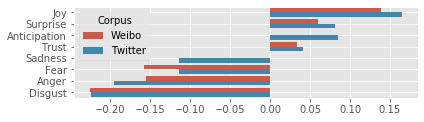

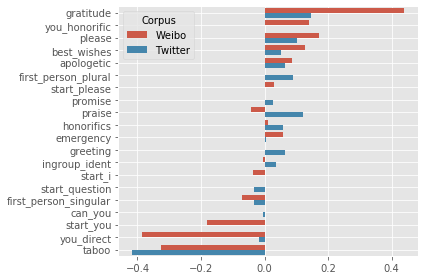

In [11]:
from itertools import product

def plotPCCs(corr_df, figsize=(6, 16), insig='hide', filename=None):
    order = corr_df.groupby('feature')['pearson_coef'].mean().sort_values(ascending=False).index
    fig, ax = plt.subplots(1,1, figsize=figsize)
    ax = sns.barplot(x='pearson_coef', y='feature', order=order, data=corr_df, hue='corpus', ax=ax, hue_order=['Weibo', 'Twitter'])
    plt.ylabel('')
    plt.xlabel('')
    plt.legend(loc='best')
    corpus_legend = ax.legend()
    corpus_legend.set_title('Corpus')
    y_axis_labels = [i.get_text() for i in ax.get_yticklabels()]
    legend_labels = ax.get_legend_handles_labels()[1]
    
    for i, (patch, (corpus, feature)) in enumerate(zip(ax.patches, product(legend_labels, y_axis_labels))):
        if_this_is_significant = corr_df.loc[(corr_df['feature']==feature) & (corr_df['corpus']==corpus), 'if_significant'].iloc[0]
        if if_this_is_significant==False:
            if insig=='hide': patch.remove()
            elif insig=='shade':
                patch.set_hatch('/////')
                plt.text(patch.get_x()+patch.get_width(), patch.get_y(), f'{i} {feature} {corpus}')
            else: raise ValueError('Unexpected argument.')

    # Add legend for statistical significance.
    if insig=='shade':
        from matplotlib.patches import Patch
        legend_elements = [ Patch(facecolor='white', edgecolor='black', label='Significant'), Patch(facecolor='white', edgecolor='black', hatch='/////', label='Insignificant')]
        significance_legend = ax.legend(handles=legend_elements, loc='lower right', title='Statistical Significance')
        ax.add_artist(corpus_legend)

    ax.grid(True)
    plt.tight_layout()
    if filename!=None:
        fig.savefig(filename)
    return ax

plotPCCs(corr_emolex_df, figsize=(6,1.8), filename=f'pcc-emolex_{FILE_SUFFIX}.png')
plotPCCs(corr_polite_df, figsize=(6,4), filename=f'pcc-politelex_{FILE_SUFFIX}.png')

In [12]:
rename_yticks = {
'Function': 'Function',
'Pronoun': '	Pronoun',
'Ppron': '		Ppron',
'I': '			I',
'We': '			We',
'You': '			You',
'Shehe': '			Shehe',
'They': '			They',
'Youpl': '			Youpl',
'Ipron': '		Ipron',
'Prep': '	Prep',
'Auxverb': '	Auxverb',
'Adverb': '	Adverb',
'Conj': '	Conj',
'Negate': '	Negate',
'Quanunit': '	Quanunit',
'Prepend': '	Prepend',
'Specart': '	Specart',
'Tensem': '	Tensem',
'Focuspast': '		Focuspast',
'Focuspresent': '		Focuspresent',
'Focusfuture': '		Focusfuture',
'Progm': '		Progm',
'Particle': '	Particle',
'Modal_pa': '		Modal_pa',
'General_pa': '		General_pa',
'Othergram': 'Othergram',
'Compare': '	Compare',
'Interrog': '	Interrog',
'Number': '	Number',
'Quant': '	Quant',
'Affect': 'Affect',
'Posemo': '	Posemo',
'Negemo': '	Negemo',
'Anx': '		Anx',
'Anger': '		Anger',
'Sad': '		Sad',
'Social': 'Social',
'Family': '	Family',
'Friend': '	Friend',
'Female': '	Female',
'Male': '	Male',
'Cogproc': 'Cogproc',
'Insight': '	Insight',
'Cause': '	Cause',
'Discrep': '	Discrep',
'Tentat': '	Tentat',
'Certain': '	Certain',
'Differ': '	Differ',
'Percept': 'Percept',
'See': '	See',
'Hear': '	Hear',
'Feel': '	Feel',
'Bio': 'Bio',
'Body': '	Body',
'Health': '	Health',
'Sexual': '	Sexual',
'Ingest': '	Ingest',
'Drives': 'Drives',
'Affiliation': '	Affiliation',
'Achieve': '	Achieve',
'Power': '	Power',
'Reward': '	Reward',
'Risk': '	Risk',
'Relativ': 'Relativ',
'Motion': '	Motion',
'Space': '	Space',
'Time': '	Time',
'Persconc': 'Persconc',
'Work': '	Work',
'Leisure': '	Leisure',
'Home': '	Home',
'Money': '	Money',
'Relig': '	Relig',
'Death': '	Death',
'Informal': 'Informal',
'Swear': '	Swear',
'Netspeak': '	Netspeak',
'Assent': '	Assent',
'Nonflu': '	Nonflu',
'Filler': '	Filler',
}

liwc_top_category_to_lower = {'function':['pronoun','ppron','i','we','you','shehe','they','youpl','ipron','prep','auxverb','adverb','conj','negate','quanunit','prepend','specart','tensem','focuspast','focuspresent','focusfuture','progm','particle','modal_pa','general_pa'],
'othergram':['compare','interrog','number','quant'],
'affect':['posemo','negemo','anx','anger','sad'],
'social':['family','friend','afemale','male','female'],
'cogproc':['insight','cause','discrep','tentat','certain','differ'],
#'percept':['see','hear','feel'],
'bio':['body','health','sexual','ingest'],
'drives':['affiliation','achieve','power','reward','risk'],
#'relativ':['motion','space','time'],
'persconc':['work','leisure','home','money','relig','death'],
'informal':['swear','netspeak','assent','nonflu','filler']}

top_level_to_full_name = {
    'function': 'Function Words', 
    'othergram': 'Other Grammatical Categories', 
    'affect': 'Affective Processes',
    'social': 'Social Processes',
    'cogproc': 'Cognitive Processes',
    #'percept': None, #'Perceptual Processes',
    'bio': 'Biological Processes',
    'drives': 'Drives',
    #'relativ': None, #'Relativity',
    'persconc': 'Personal Concerns',
    'informal': 'Informal language',
}

liwc_ctgys_to_full_name = {
'Achieve'		: 'Achievement (Achieve)',
 'Adverb'		: 'Common Adverbs (Adverb)',
 'Anx'			: 'Anxiety (Anx)',
 'Auxverb'		: 'Auxiliary verbs (Auxverb)',
 'Bio'			: 'Biological processes (Bio)',
 'Cause'		: 'Causation (Cause)',
 'Certain'		: 'Certainty (Certain)',
 'Cogproc'		: 'Cognitive processes (Cogproc)',
 'Compare'		: 'Comparatives (Compare)',
 'Conj'			: 'Conjunctions (Conj)',
 'Differ'		: 'Differentiation (Differ)',
 'Female'		: 'Female references (Female)',
 'Filler'		: 'Fillers (Filler)',
 'Focusfuture'	: 'Future focus (Focusfuture)',
 'Focuspresent'	: 'Present focus (Focuspresent)',
 'Friend'		: 'Friends (Friend)',
 'Function'		: 'Function words (Function)',
 'I'			: 'First person singular (I)',
 'Informal'		: 'Informal language (Informal)',
 'Ingest'		: 'Ingestion (Ingest)',
 'Interrog'		: 'Interrogatives (Interrog)',
 'Ipron'		: 'Impersonal pronouns (Ipron)',
 'Male'			: 'Male references (Male)',
 'Negate'		: 'Negations (Negate)',
 'Negemo'		: 'Negative emotion (Negemo)',
 'Nonflu'		: 'Nonfluencies (Nonflu)',
 'Number'		: 'Numbers (Number)',
 'Percept'		: 'Perceptual processes (Percept)',
 'Posemo'		: 'Positive emotion (Posemo)',
 'Ppron'		: 'Personal pronouns (Ppron)',
 'Prep'			: 'Prepositions (Prep)',
 'Pronoun'		: 'Total pronouns (Pronoun)',
 'Quant'		: 'Quantifiers (Quant)',
 'Relativ'		: 'Relativity (Relativ)',
 'Shehe'		: 'Third person singular (Shehe)',
 'Social'		: 'Social processes (Social)',
 'Swear'		: 'Swear words (Swear)',
 'Tentat'		: 'Tentative (Tentat)',
 'They'			: 'Third person plural (They)',
 'We'			: 'First person plural (We)',
 'You'			: 'Second Person (You)'}

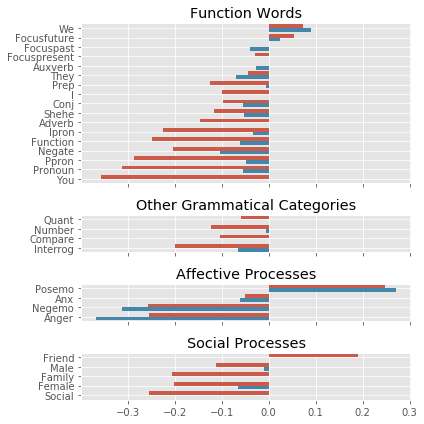

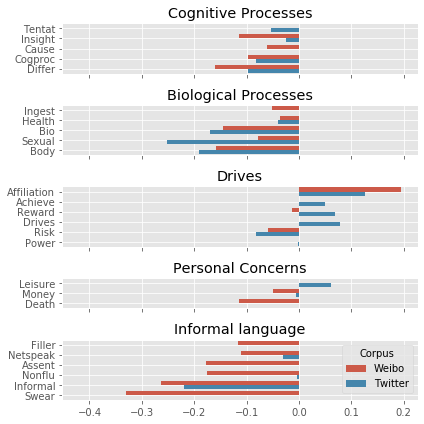

In [13]:
def findTopCategory(feature_name):
    for k,v in liwc_top_category_to_lower.items():
        if feature_name in v or feature_name==k: return k
corr_liwc_df = corr_liwc_df.assign(top_level=corr_liwc_df['feature'].str.lower().apply(findTopCategory))

liwc_top_ctgys = liwc_top_category_to_lower.keys()
n_subplots = len(liwc_top_ctgys)
assert n_subplots==9

# Which side of the two-column plot should we draw each top-level category on? 0 = left; 1 = right.
left_or_right = pd.Series({'function':0, 'othergram':0, 'affect':0, 'social':0, 'cogproc':1, 'bio':1, 'drives':1, 'persconc':1, 'informal':1})

numOfSubCtgys = lambda top_ctgy: (corr_liwc_df['top_level']==top_ctgy).sum()
ratios = pd.Series({top_ctgy: numOfSubCtgys(top_ctgy) for top_ctgy in liwc_top_ctgys})

num_subplots_l = (left_or_right==0).sum()
ratios_l = ratios.loc[left_or_right==0]
fig_l, axes_l = plt.subplots(num_subplots_l, 1, figsize=(6, 6), 
                             sharex=True, gridspec_kw={'height_ratios': ratios_l})

num_subplots_r = (left_or_right==1).sum()
ratios_r = ratios.loc[left_or_right==1]
fig_r, axes_r = plt.subplots(num_subplots_r, 1, figsize=(6, 6), 
                             sharex=True, gridspec_kw={'height_ratios': ratios_r})

figs = [fig_l, fig_r]
axes = list(axes_l) + list(axes_r)

for i, ctgy in enumerate(liwc_top_ctgys):
    # Look up variables from tables.
    # Get a list of sub-categories to this top-level category.
    sub_ctgys = liwc_top_category_to_lower[ctgy]
    full_name = top_level_to_full_name[ctgy]
    # Which side to paint this top category on.
    side = left_or_right[ctgy]
    
    fix = figs[side]
    ax = axes[i]

    # Get correlations from both corpora about this top-level categories.
    corr_df = corr_liwc_df[corr_liwc_df['top_level']==ctgy]
    order = corr_df.groupby('feature')['pearson_coef'].mean().sort_values(ascending=False).index
    sns.barplot(x='pearson_coef', y='feature', order=order, data=corr_df, hue='corpus', ax=ax, hue_order=['Weibo', 'Twitter'])
    
    # Remove insignificant bars.
    y_axis_labels = [i.get_text() for i in ax.get_yticklabels()]
    legend_labels = ax.get_legend_handles_labels()[1]
    for i, (patch, (corpus, feature)) in enumerate(zip(ax.patches, product(legend_labels, y_axis_labels))):
        if_this_is_significant = corr_df.loc[(corr_df['feature']==feature) & (corr_df['corpus']==corpus), 'if_significant'].iloc[0]
        if if_this_is_significant==False: patch.remove()
    
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.get_legend().remove()
    ax.grid(True)
    ax.set_title(full_name)

# Only show legend in the last subplot.
corpus_legend = ax.legend()
corpus_legend.set_title('Corpus')

fig_l.subplots_adjust(hspace=.5)
fig_r.subplots_adjust(hspace=.5)
fig_l.tight_layout()
fig_r.tight_layout()
fig_l.savefig(f'pcc-liwc_l_{FILE_SUFFIX}.png')
fig_r.savefig(f'pcc-liwc_r_{FILE_SUFFIX}.png')
plt.show()
#yax = ax.get_yaxis()
#ax.set_yticklabels(ax.get_yticklabels(), ha = 'left')
#yax.set_tick_params(pad=80)

   - Common Features: affect, bio, cogproc, drives, function, informal, othergram, persconc, social
   - Features to keep: affect, bio, cogproc, drives, function, informal, othergram, social


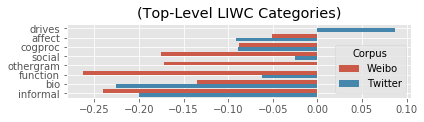

In [14]:
aggregateLiwcCntsByTopLvCtgy = lambda df: pd.DataFrame({top_level: df.T.reindex(pd.Series(categories).str.title()).sum().astype(int) for top_level, categories in liwc_top_category_to_lower.items()})
twitr_liwc_tLv_cnts_df = aggregateLiwcCntsByTopLvCtgy(twitr_liwc_cnts_df)
weibo_liwc_tLv_cnts_df = aggregateLiwcCntsByTopLvCtgy(weibo_liwc_cnts_df)
corr_liwc_tLv_df = computePCCsForFeatureSet(twitr_liwc_tLv_cnts_df, weibo_liwc_tLv_cnts_df)

plotPCCs(corr_liwc_tLv_df, figsize=(6,1.8))
plt.title('(Top-Level LIWC Categories)')
plt.tight_layout()
plt.savefig(f'pcc-liwc-topLv_{NUM_POSTS}_Weibo{FILE_SUFFIX}.png')
plt.show()

(March 2020) Find features that correlates most differently with pltns scores across sentiments.

In [15]:
# Concat across corpora:
cnts_df = pd.concat([twitr_cnts_df, weibo_cnts_df])
scores = pd.concat([twitr_scores, weibo_scores])
# Keep only shared features:
cnts_df.dropna(axis=1, inplace=True)

if_positive = cnts_df[('LIWC', 'Posemo')]>cnts_df[('LIWC', 'Negemo')]
if_negative = cnts_df[('LIWC', 'Posemo')]<cnts_df[('LIWC', 'Negemo')]

n = min(sum(if_positive), sum(if_negative))//100*100
print(f"There are {sum(if_positive)} positive posts and {sum(if_negative)} negative posts. We take {n} posts in each.")

pos_index = cnts_df.index[if_positive].to_series().sample(n).index
neg_index = cnts_df.index[if_negative].to_series().sample(n).index

pos_cnts_df = cnts_df.loc[pos_index]
neg_cnts_df = cnts_df.loc[neg_index]
pos_scores = scores.loc[pos_index]
neg_scores = scores.loc[neg_index]

There are 3824 positive posts and 2477 negative posts. We take 2400 posts in each.


In [16]:
def getCorrForSenti(this_cnts_df, this_scores, if_remove_insignificant=False):
    this_corr_df = this_cnts_df.apply(lambda x: stats.pearsonr(x, this_scores)).T
    this_corr_df.columns = ['pearson_coef', 'p_value']
    this_corr_df['if_significant'] = this_corr_df['p_value']<0.01
    if if_remove_insignificant:
        this_corr_df = this_corr_df.loc[this_corr_df['if_significant']]
    return this_corr_df

def getCorrAcrossSenti(if_remove_insignificant=False):
    pos_corr_df = getCorrForSenti(pos_cnts_df, pos_scores, if_remove_insignificant)
    neg_corr_df = getCorrForSenti(neg_cnts_df, neg_scores, if_remove_insignificant)

    pos_corr_df.dropna(inplace=True)
    neg_corr_df = neg_corr_df.reindex(pos_corr_df.index)
    neg_corr_df.dropna(inplace=True)
    pos_corr_df = pos_corr_df.reindex(neg_corr_df.index)
    assert (pos_corr_df.index==neg_corr_df.index).all()

    return stats.pearsonr(
        pos_corr_df['pearson_coef'], 
        neg_corr_df['pearson_coef'])

senti_corr_withInsig_r, senti_corr_withInsig_p = getCorrAcrossSenti(if_remove_insignificant=False)
senti_corr_signiOnly_r, senti_corr_signiOnly_p = getCorrAcrossSenti(if_remove_insignificant=True)

/home/myli/miniconda3/envs/main/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [17]:
senti_corr_withInsig_r, senti_corr_withInsig_p

(0.5082449913399197, 4.240348816192041e-08)

In [18]:
senti_corr_signiOnly_r, senti_corr_signiOnly_p

(0.5599374886652227, 6.350385659430543e-05)

In [19]:
pos_corr_df = getCorrForSenti(pos_cnts_df, pos_scores, if_remove_insignificant=True)
neg_corr_df = getCorrForSenti(neg_cnts_df, neg_scores, if_remove_insignificant=True)

In [20]:
abs_diff_in_r_df = (pos_corr_df['pearson_coef']-neg_corr_df['pearson_coef']).dropna().abs().sort_values(ascending=False).reset_index()
abs_diff_in_r_df.columns = ['lexicon', 'feature', 'abs_diff_in_r']
abs_diff_in_r_df.to_csv(f'abs_diff_of_PCCs_across_PosNeg_{FILE_SUFFIX}.csv')
abs_diff_in_r_df

,lexicon,feature,abs_diff_in_r
0,LIWC,Cogproc,0.310524
1,PoliteLex,hedge,0.306207
2,LIWC,Tentat,0.299690
3,LIWC,Adverb,0.271456
4,LIWC,Auxverb,0.260571
5,LIWC,Differ,0.257196
6,LIWC,Discrep,0.255872
7,LIWC,Negate,0.255779
8,LIWC,Insight,0.246420
9,LIWC,Compare,0.237340
